Driving Behavior Summary:
Driving_Category
Risky       29837
Safe        12574
Moderate     4150
Name: count, dtype: int64


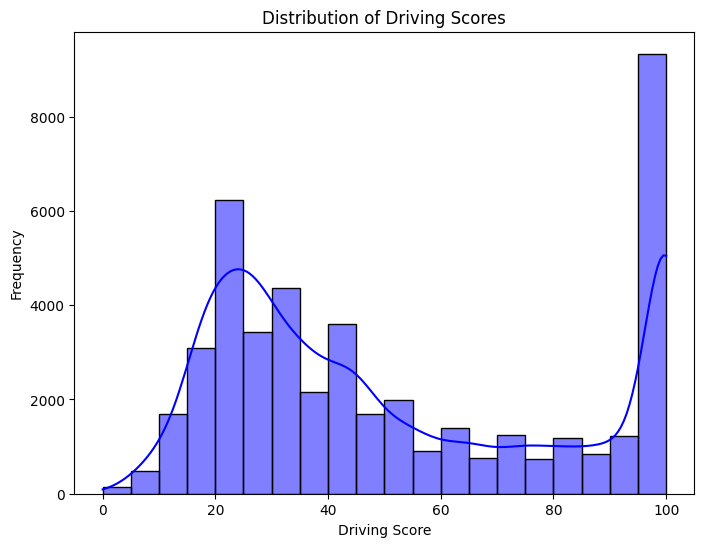

C:\Users\anush\AppData\Local\Temp\ipykernel_24052\3957214261.py:171: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


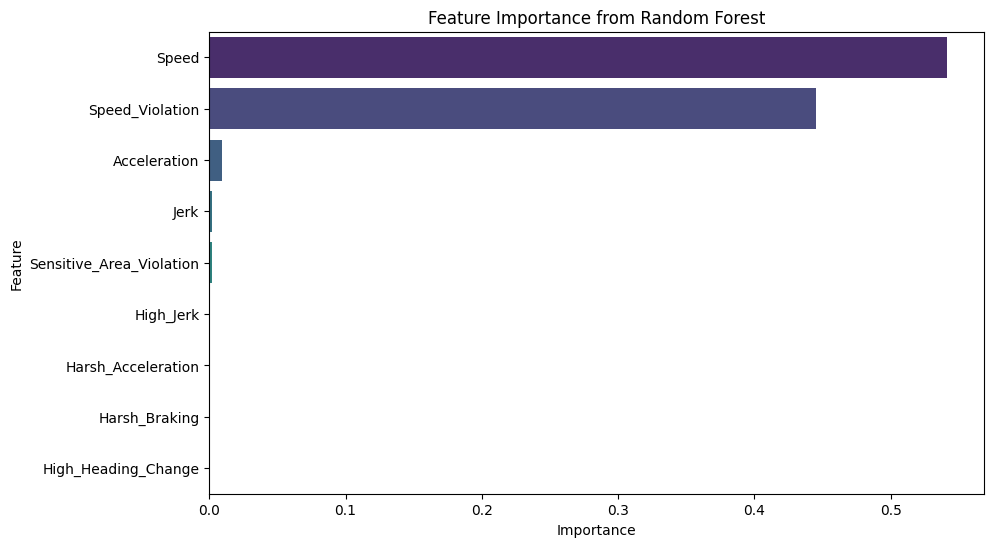

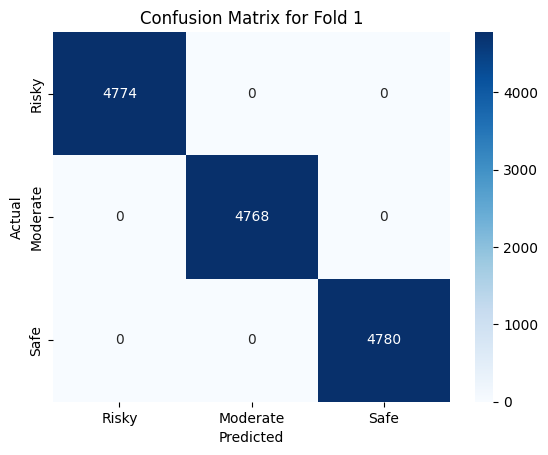

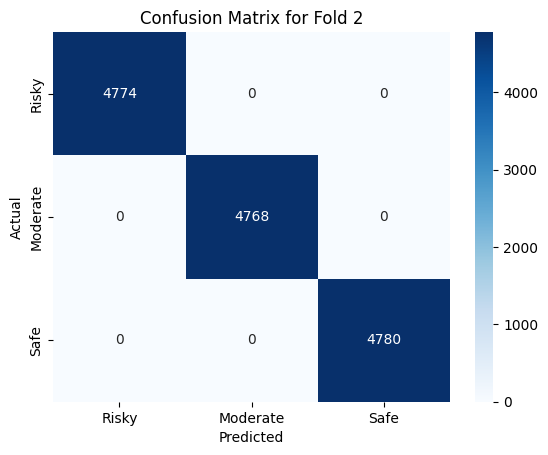

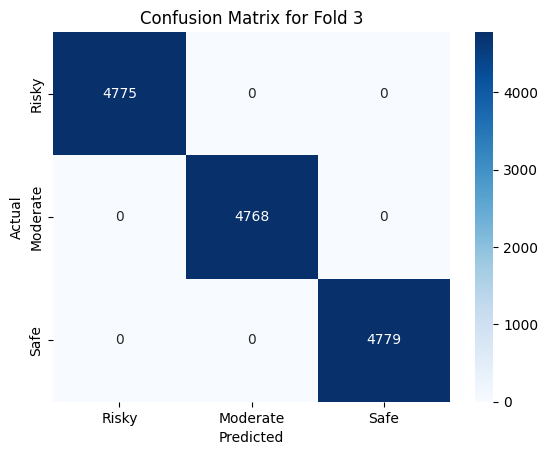

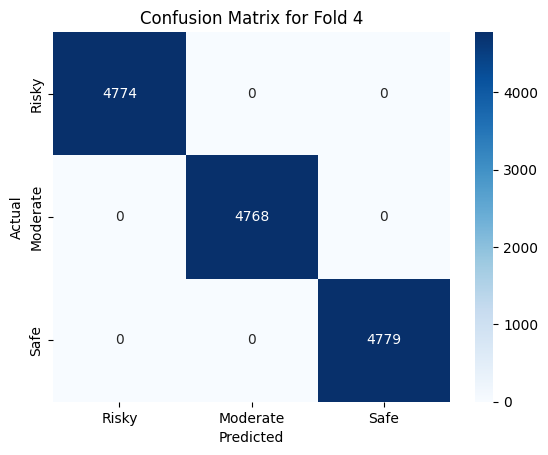

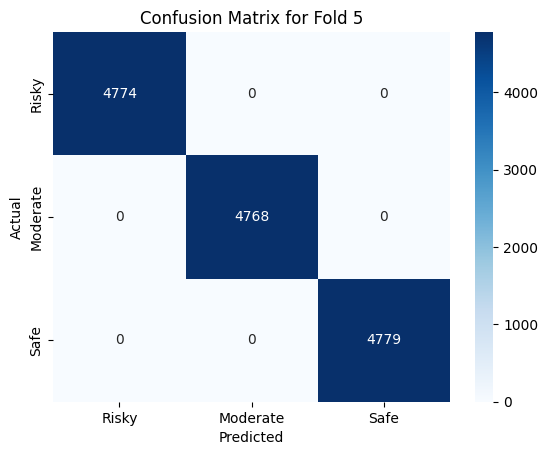


Average Validation Accuracy: 1.0000
Test Set Accuracy: 1.0000


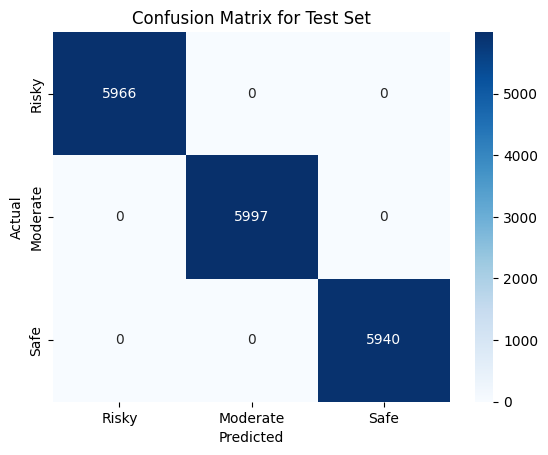

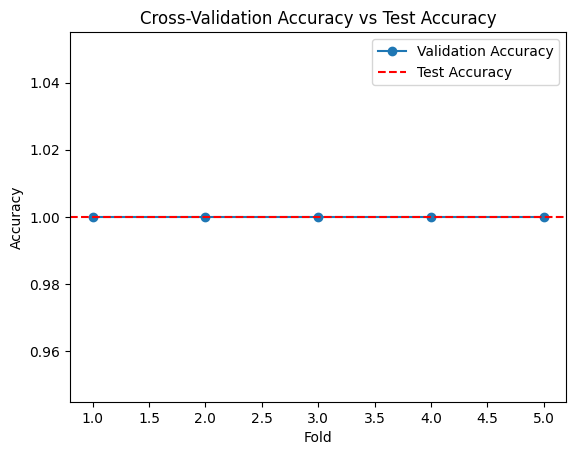

In [5]:
import os
import pandas as pd
import numpy as np
from haversine import haversine, Unit
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from scipy.stats import zscore

# Load sensitive locations
sensitive_locations = pd.read_csv('../data/sensitive_location.csv')

# Helper functions
def calculate_jerk(acceleration, time_step):
    """Calculate the jerk (rate of change of acceleration)."""
    jerk = acceleration.diff() / time_step.diff()
    jerk.fillna(0, inplace=True)  # Handle NaN for the first row
    jerk.replace([np.inf, -np.inf], 0, inplace=True)  # Replace infinities with 0
    return jerk

def check_sensitive_location(row, sensitive_locations, speed_limit):
    """Check if the driver violates speed limits in sensitive areas."""
    driver_location = (row['Latitude'], row['Longitude'])
    for _, loc in sensitive_locations.iterrows():
        sensitive_location = (loc['Latitude'], loc['Longitude'])
        distance = haversine(driver_location, sensitive_location, unit=Unit.METERS)
        if distance <= 300 and row['Speed'] > (speed_limit * 1000 / 3600):
            return 1
    return 0

def categorize_driving(score):
    """Categorize driving behavior based on the score."""
    if score >= 80:
        return 'Safe'
    elif 60 <= score < 80:
        return 'Moderate'
    else:
        return 'Risky'

def remove_outliers(df, columns):
    """Remove outliers from specified columns using the z-score."""
    for col in columns:
        z_scores = zscore(df[col])
        df = df[(z_scores < 3) & (z_scores > -3)]
    return df

def clean_data(df):
    """Clean the data by handling NaN values and outliers."""
    # Drop rows with NaN in critical columns
    critical_columns = ['Speed', 'Acceleration', 'TimeStep', 'Latitude', 'Longitude', 'HeadingChange']
    df = df.dropna(subset=critical_columns)

    # Fill NaN values in non-critical columns with 0
    df.fillna(0, inplace=True)

    # Remove outliers
    df = remove_outliers(df, ['Speed', 'Acceleration', 'HeadingChange'])

    return df

def analyze_driving_data(df):
    """Analyzes driving data based on defined metrics and thresholds."""
    # Define thresholds
    speed_limit = 30  # Speed limit in km/h
    harsh_acceleration_threshold = 3.0  # Harsh acceleration in m/s^2
    harsh_braking_threshold = -3.0  # Harsh braking in m/s^2
    jerk_threshold = 5.0  # Jerk threshold in m/s^3
    heading_change_threshold = 30.0  # Heading change threshold in degrees

    # Clean the data
    df = clean_data(df)

    # Ensure speed is non-negative
    df['Speed'] = df['Speed'].abs()

    # Calculate Jerk
    df['Jerk'] = calculate_jerk(df['Acceleration'], df['TimeStep'])

    # Initialize driving score
    df['Driving_Score'] = 100

    # Calculate penalties
    df['Speed_Violation'] = np.where(df['Speed'] > speed_limit, (df['Speed'] - speed_limit) * 2, 0)
    df['Harsh_Acceleration'] = np.where(df['Acceleration'] > harsh_acceleration_threshold, 
                                         (df['Acceleration'] - harsh_acceleration_threshold) * 2, 0)
    df['Harsh_Braking'] = np.where(df['Acceleration'] < harsh_braking_threshold, 
                                    (harsh_braking_threshold - df['Acceleration']) * 2, 0)
    df['High_Jerk'] = np.where(abs(df['Jerk']) > jerk_threshold, 
                               abs(df['Jerk'] - jerk_threshold) * 2, 0)
    df['High_Heading_Change'] = np.where(abs(df['HeadingChange']) > heading_change_threshold, 
                                         abs(df['HeadingChange'] - heading_change_threshold) * 2, 0)

    # Deduct points based on violations
    df['Driving_Score'] -= df[['Speed_Violation', 'Harsh_Acceleration', 'Harsh_Braking', 
                               'High_Jerk', 'High_Heading_Change']].sum(axis=1)

    # Sensitive location violations
    df['Sensitive_Area_Violation'] = df.apply(lambda row: check_sensitive_location(row, sensitive_locations, speed_limit), axis=1)
    df['Driving_Score'] -= df['Sensitive_Area_Violation'] * 5

    # Ensure scores are bounded between 0 and 100
    df['Driving_Score'] = df['Driving_Score'].clip(lower=0, upper=100)

    # Categorize driving behavior
    df['Driving_Category'] = df['Driving_Score'].apply(categorize_driving)

    return df

# Load driving data
driving_data = pd.read_csv('../data/driving_data.csv')

# Analyze driving data
analyzed_data = analyze_driving_data(driving_data)
analyzed_data.to_csv('../data/analyzed_driving_data.csv', index=False)

# Summarize results
print("Driving Behavior Summary:")
print(analyzed_data['Driving_Category'].value_counts())

# Plot distribution of driving scores
plt.figure(figsize=(8, 6))
sns.histplot(analyzed_data['Driving_Score'], bins=20, kde=True, color='blue')
plt.title('Distribution of Driving Scores')
plt.xlabel('Driving Score')
plt.ylabel('Frequency')
plt.show()

# Prepare data for model training
features = ['Speed', 'Acceleration', 'Jerk', 'High_Jerk', 'Speed_Violation', 
            'Harsh_Acceleration', 'Harsh_Braking', 'Sensitive_Area_Violation', 'High_Heading_Change']
target = 'Driving_Category'

X = analyzed_data[features]
y = analyzed_data[target].map({'Safe': 2, 'Moderate': 1, 'Risky': 0})

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_resampled), y=y_resampled)
class_weights_dict = dict(enumerate(class_weights))

# Models
rf_model = RandomForestClassifier(random_state=42, class_weight=class_weights_dict)
gbc_model = GradientBoostingClassifier(random_state=42)

# Ensemble Model
ensemble_model = VotingClassifier(estimators=[('rf', rf_model), ('gbc', gbc_model)], voting='soft')

# Train Random Forest for feature importance
rf_model.fit(X_train, y_train)
feature_importances = rf_model.feature_importances_

# Plot feature importance
plt.figure(figsize=(10, 6))
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Stratified K-Fold Cross-Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), start=1):
    # Convert y_train to numpy for indexing compatibility
    y_train_np = y_train.to_numpy()
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train_np[train_idx], y_train_np[val_idx]

    # Train ensemble model
    ensemble_model.fit(X_train_fold, y_train_fold)

    # Validate
    y_val_pred = ensemble_model.predict(X_val_fold)
    accuracy = accuracy_score(y_val_fold, y_val_pred)
    accuracy_scores.append(accuracy)

    # Confusion Matrix
    cm = confusion_matrix(y_val_fold, y_val_pred)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Risky', 'Moderate', 'Safe'], yticklabels=['Risky', 'Moderate', 'Safe'])
    plt.title(f'Confusion Matrix for Fold {fold}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Average Validation Accuracy
print(f"\nAverage Validation Accuracy: {np.mean(accuracy_scores):.4f}")

# Test Set Evaluation
y_test_pred = ensemble_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Set Accuracy: {test_accuracy:.4f}")

# Confusion Matrix for Test Set
cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure()
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Risky', 'Moderate', 'Safe'], yticklabels=['Risky', 'Moderate', 'Safe'])
plt.title('Confusion Matrix for Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Cross-Validation vs Test Accuracy Plot
plt.figure()
plt.plot(range(1, 6), accuracy_scores, marker='o', label='Validation Accuracy')
plt.axhline(test_accuracy, color='red', linestyle='--', label='Test Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Accuracy vs Test Accuracy')
plt.legend()
plt.show()
